SSE 50ETF COMPREHENSIVE OPTIONS STRATEGIES BACKTEST
Testing Strategies:
1. Long Call
2. Long Put
3. Bull Call Spread
4. Bear Put Spread
5. Long Straddle
6. Long Strangle
7. Short Straddle
8. Short Strangle

Running comprehensive options strategy backtest...
Total 50ETF options found: 168
Available strikes: [0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 2.35, 2.4, 2.45, 2.5, 2.55, 2.6, 2.65, 2.7, 2.75, 2.8, 2.85, 2.9, 2.95, 3.0]

--- Testing Long Call (Strike: 2.8) ---

--- Testing Long Put (Strike: 2.7) ---

--- Testing Bull Call Spread (2.7/2.8) ---

--- Testing Bear Put Spread (2.7/2.6) ---

--- Testing Long Straddle (Strike: 2.75) ---

--- Testing Long Strangle (Call: 2.85, Put: 2.65) ---

--- Testing Short Straddle (Strike: 2.75) ---

--- Testing Short Strangle (Call: 2.85, Put: 2.65) ---

COMPREHENSIVE OPTIONS STRATEGIES BACKTEST SUMMARY
        Strategy            Parameters Initial Premium Final Value Total Return (%) Expected Payoff Bull Scenario Base Scenar

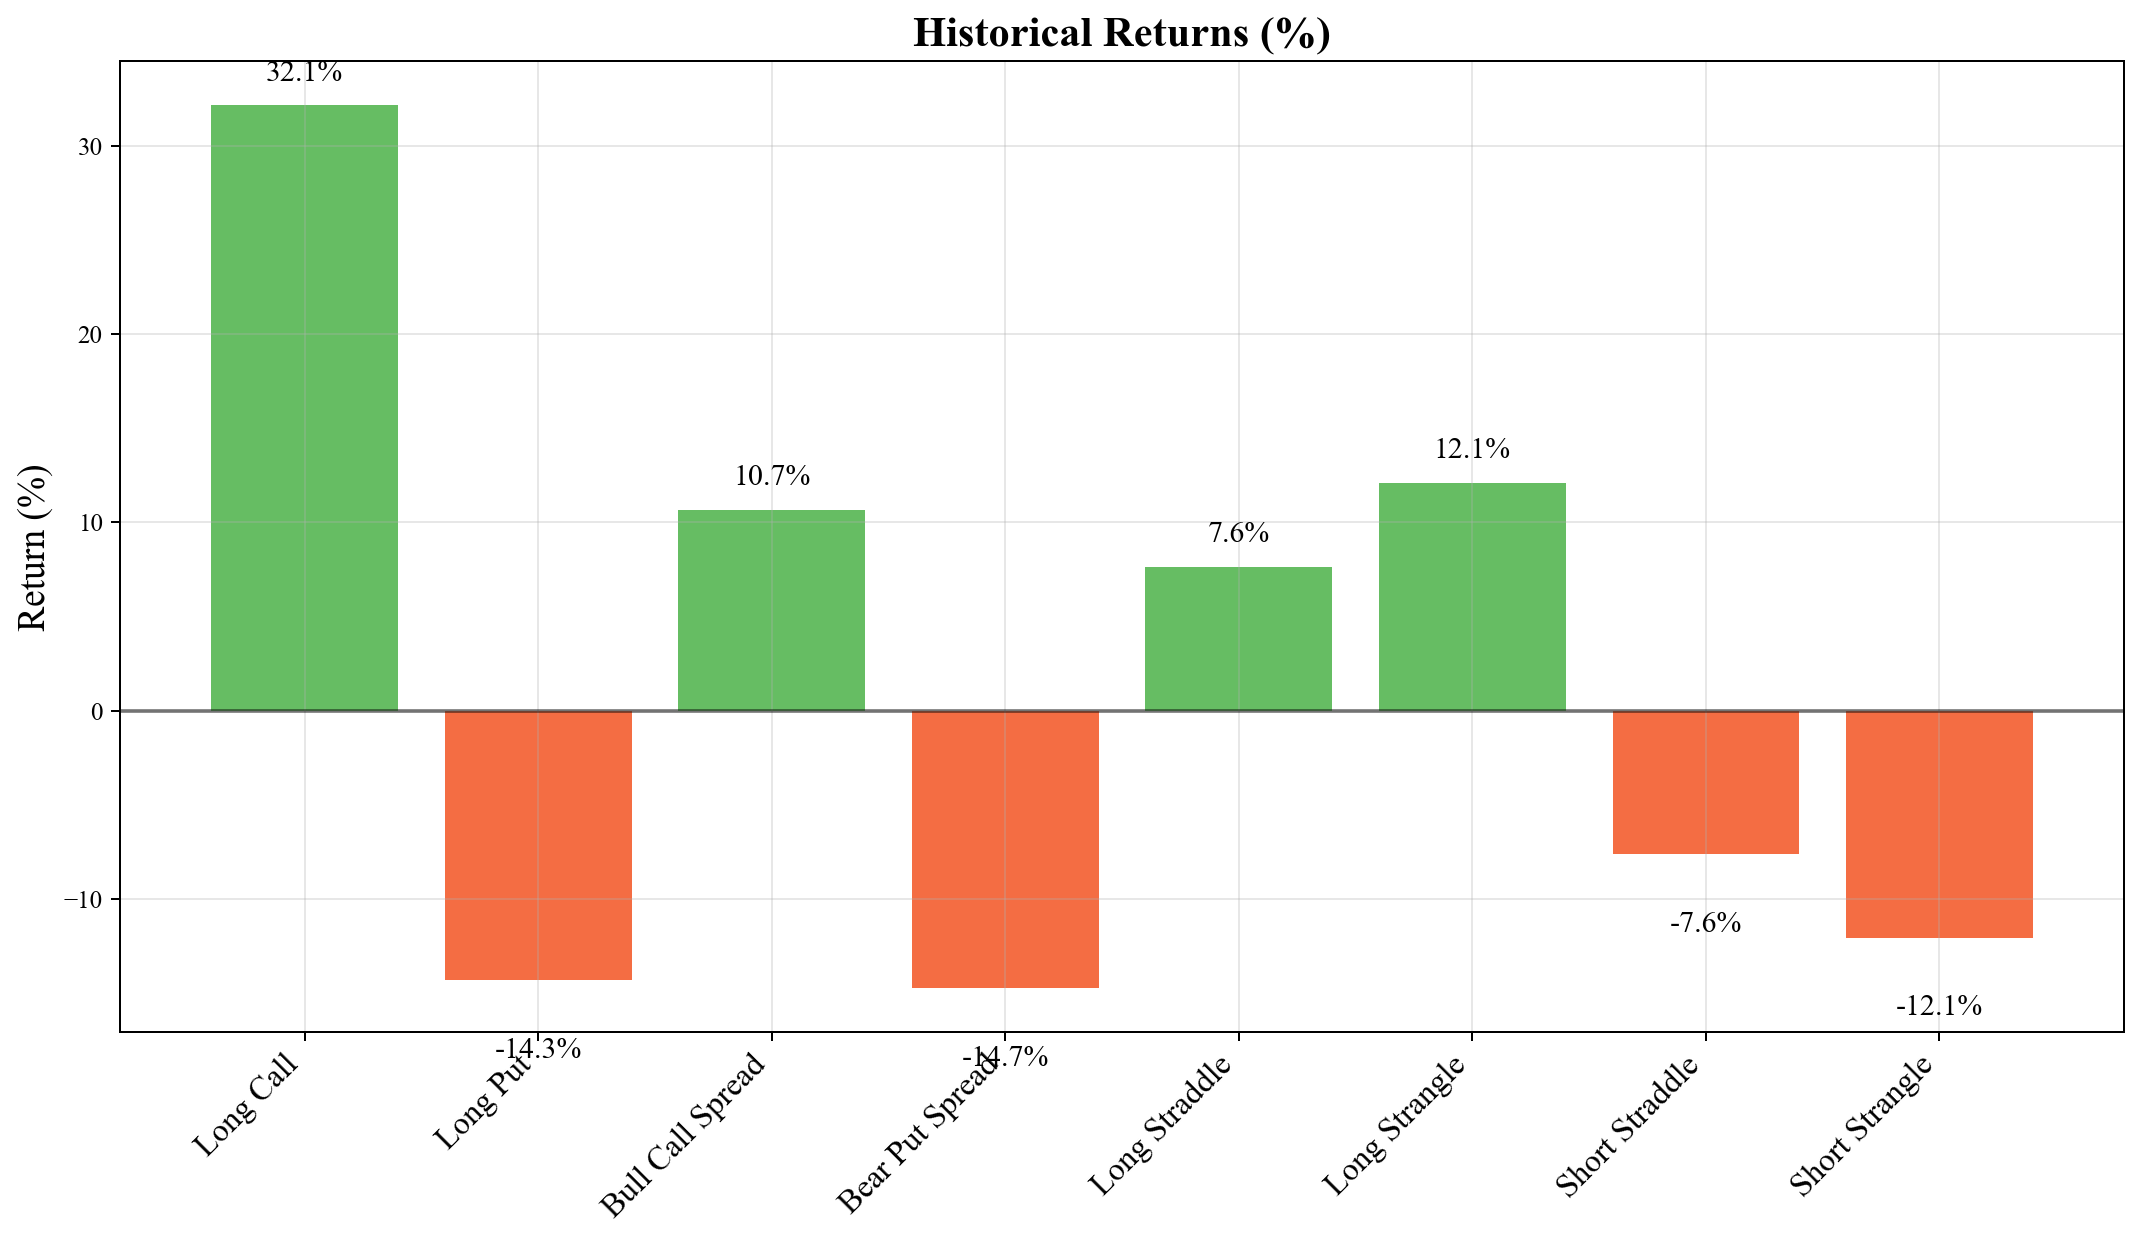

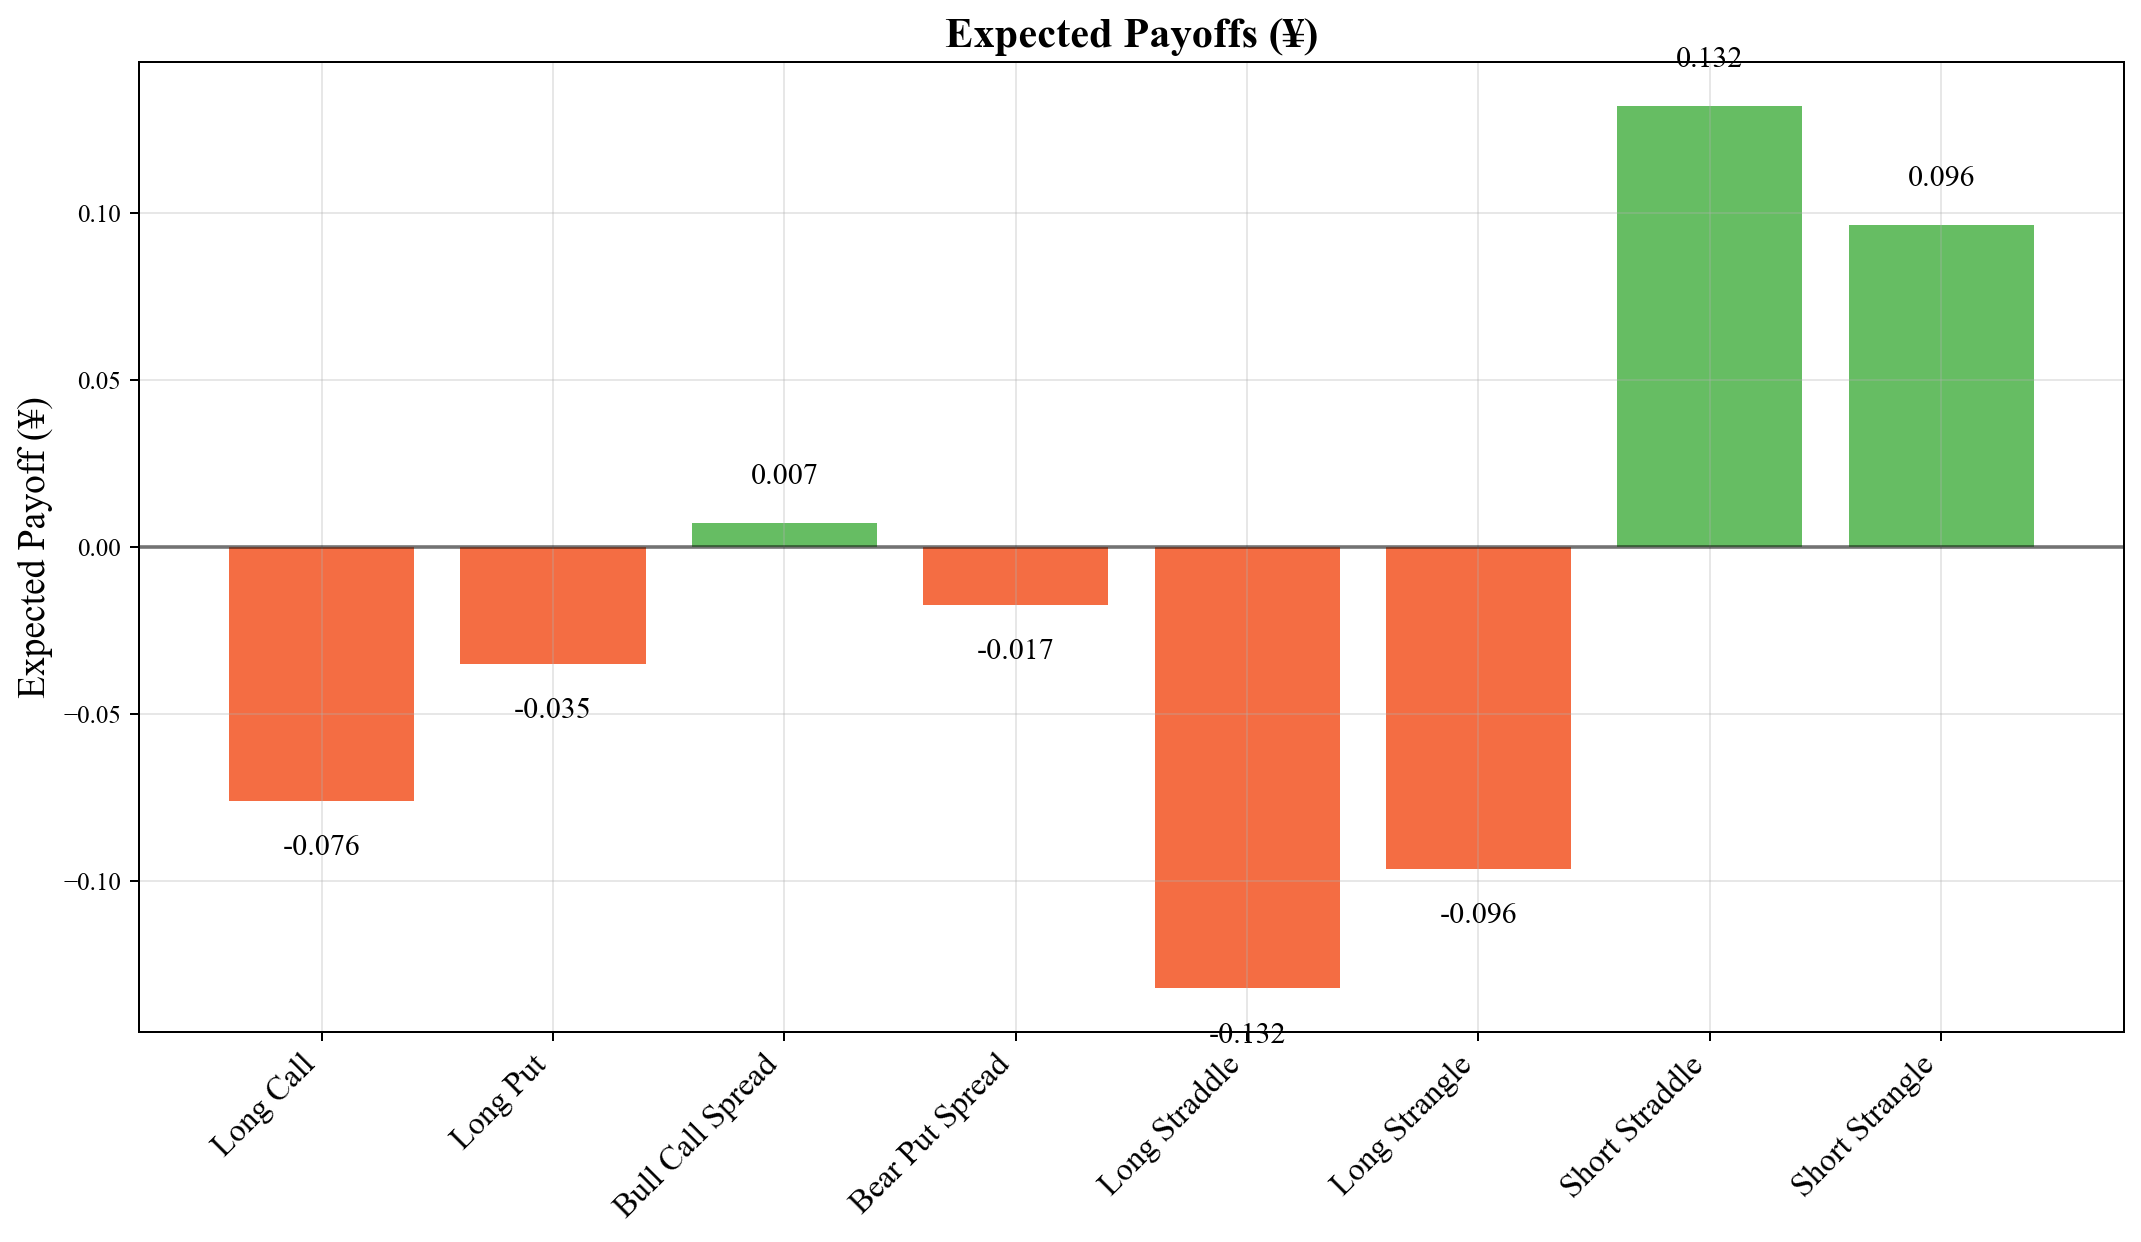

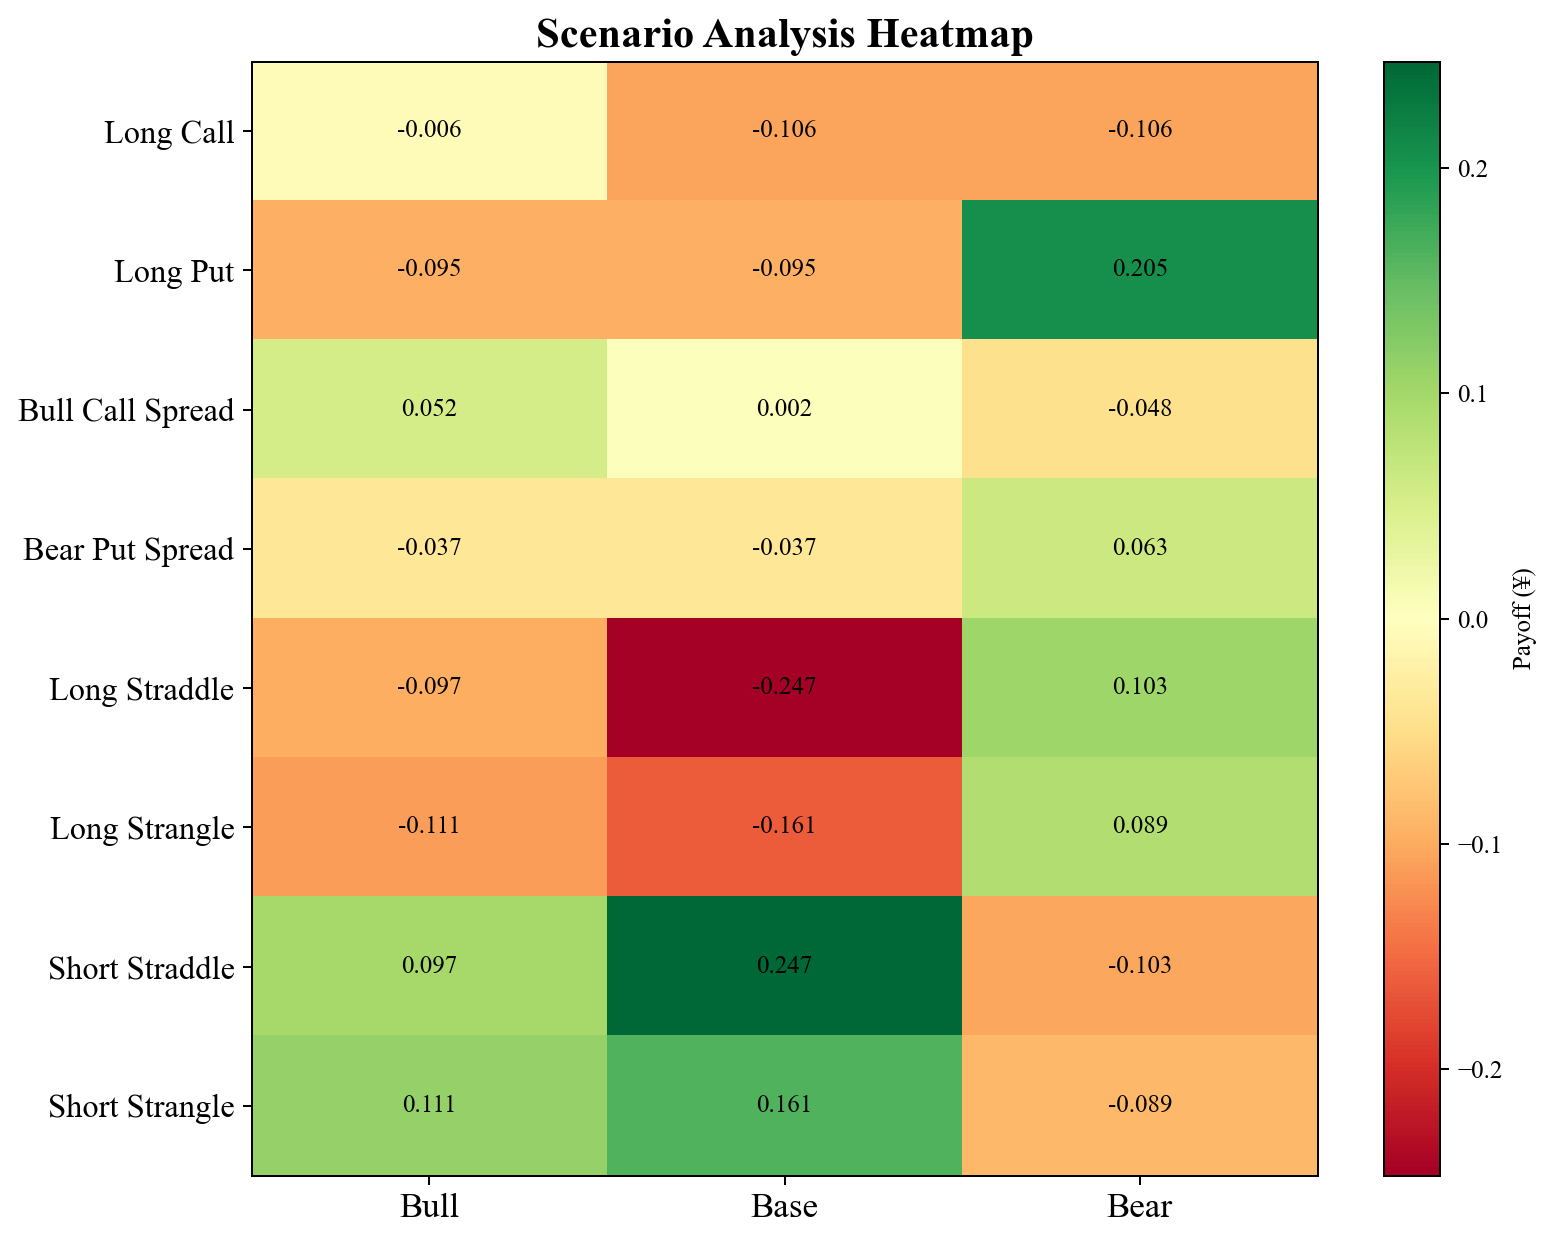

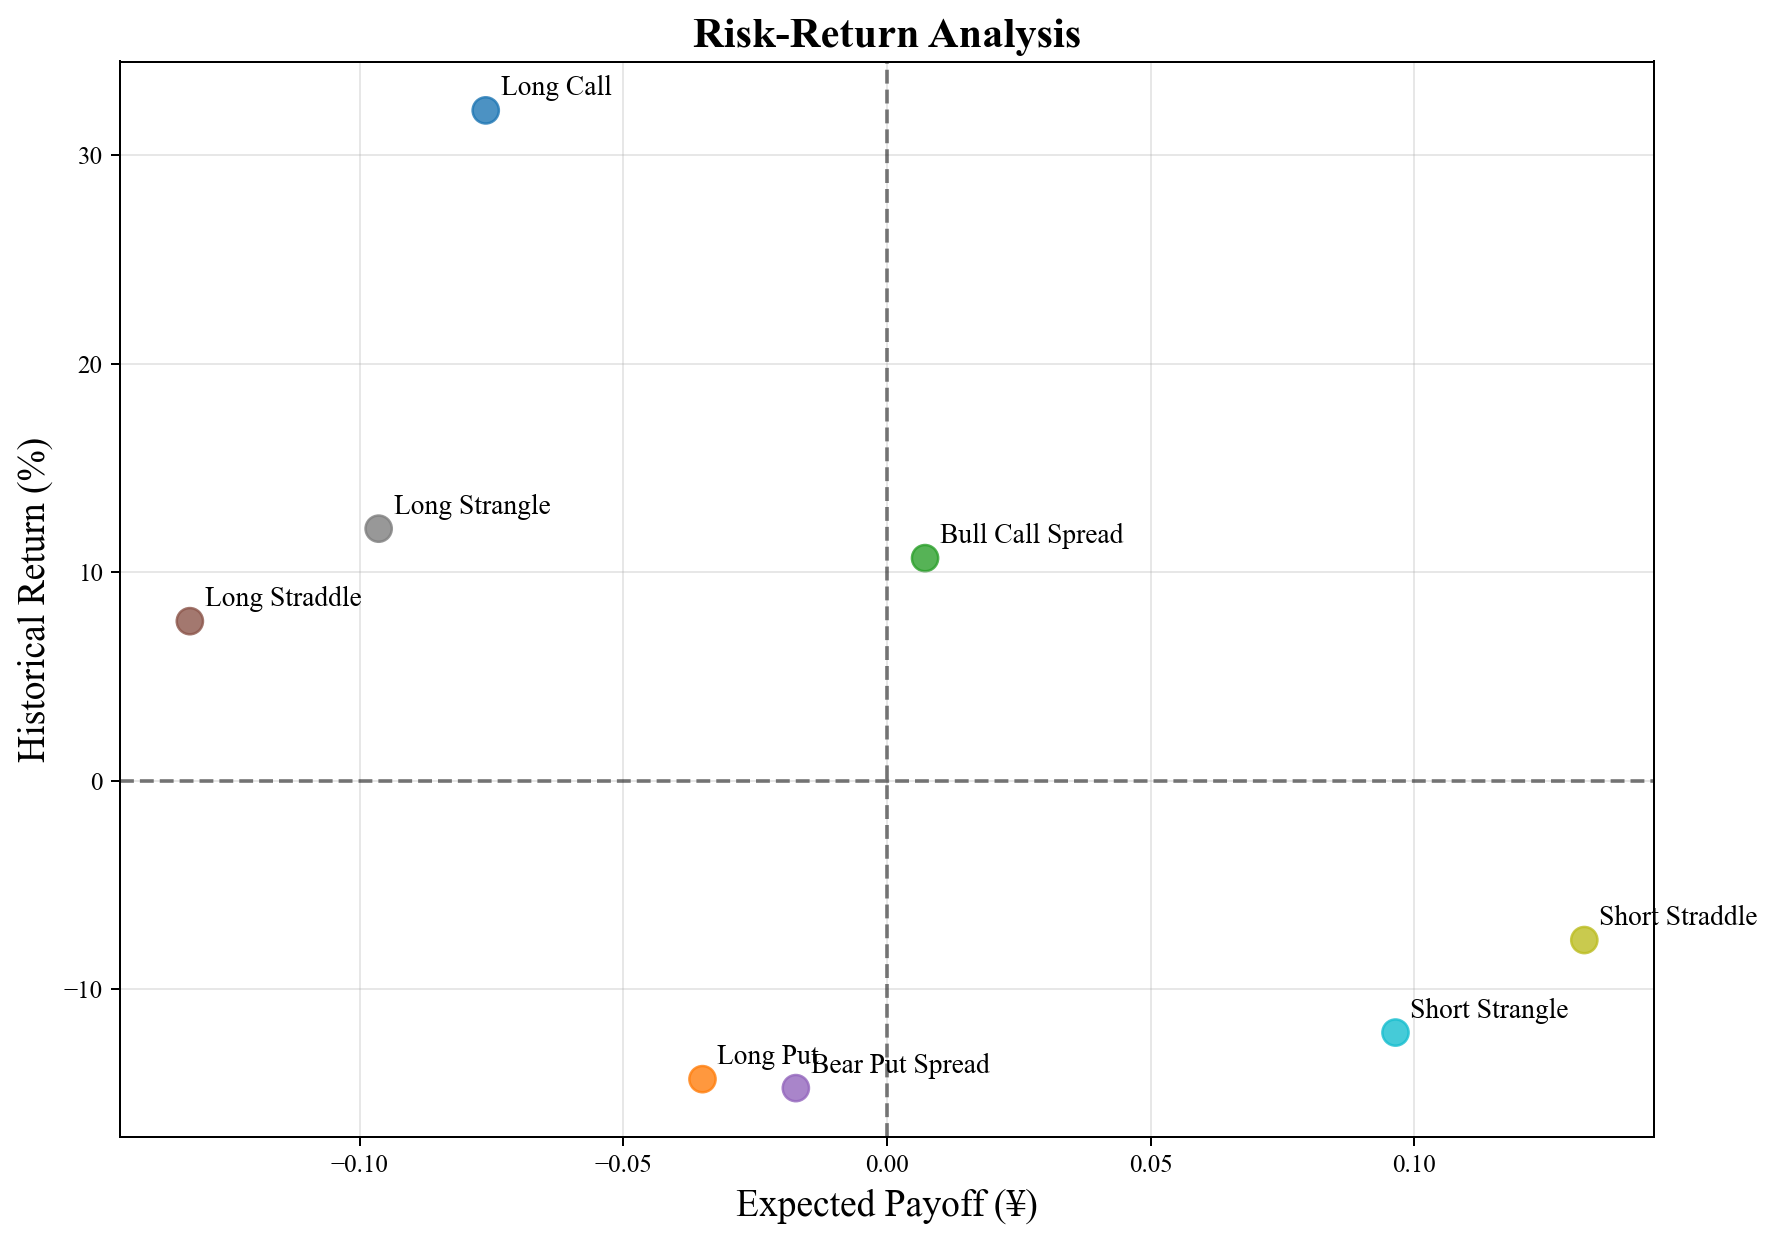


VOLATILITY SENSITIVITY ANALYSIS

Expected Payoffs under Different Volatility Scenarios:
Volatility        Base (20%)  High (22%)  Low (18%)
Strategy                                           
Bear Put Spread    -0.005864   -0.007918  -0.003508
Bull Call Spread    0.004523    0.004792   0.004221
Long Call          -0.014614   -0.020788  -0.008484
Long Put            0.021651    0.015746   0.027479
Long Straddle      -0.011624   -0.024260   0.001010
Long Strangle       0.013859    0.003305   0.024000
Short Straddle      0.011624    0.024260  -0.001010
Short Strangle     -0.013859   -0.003305  -0.024000


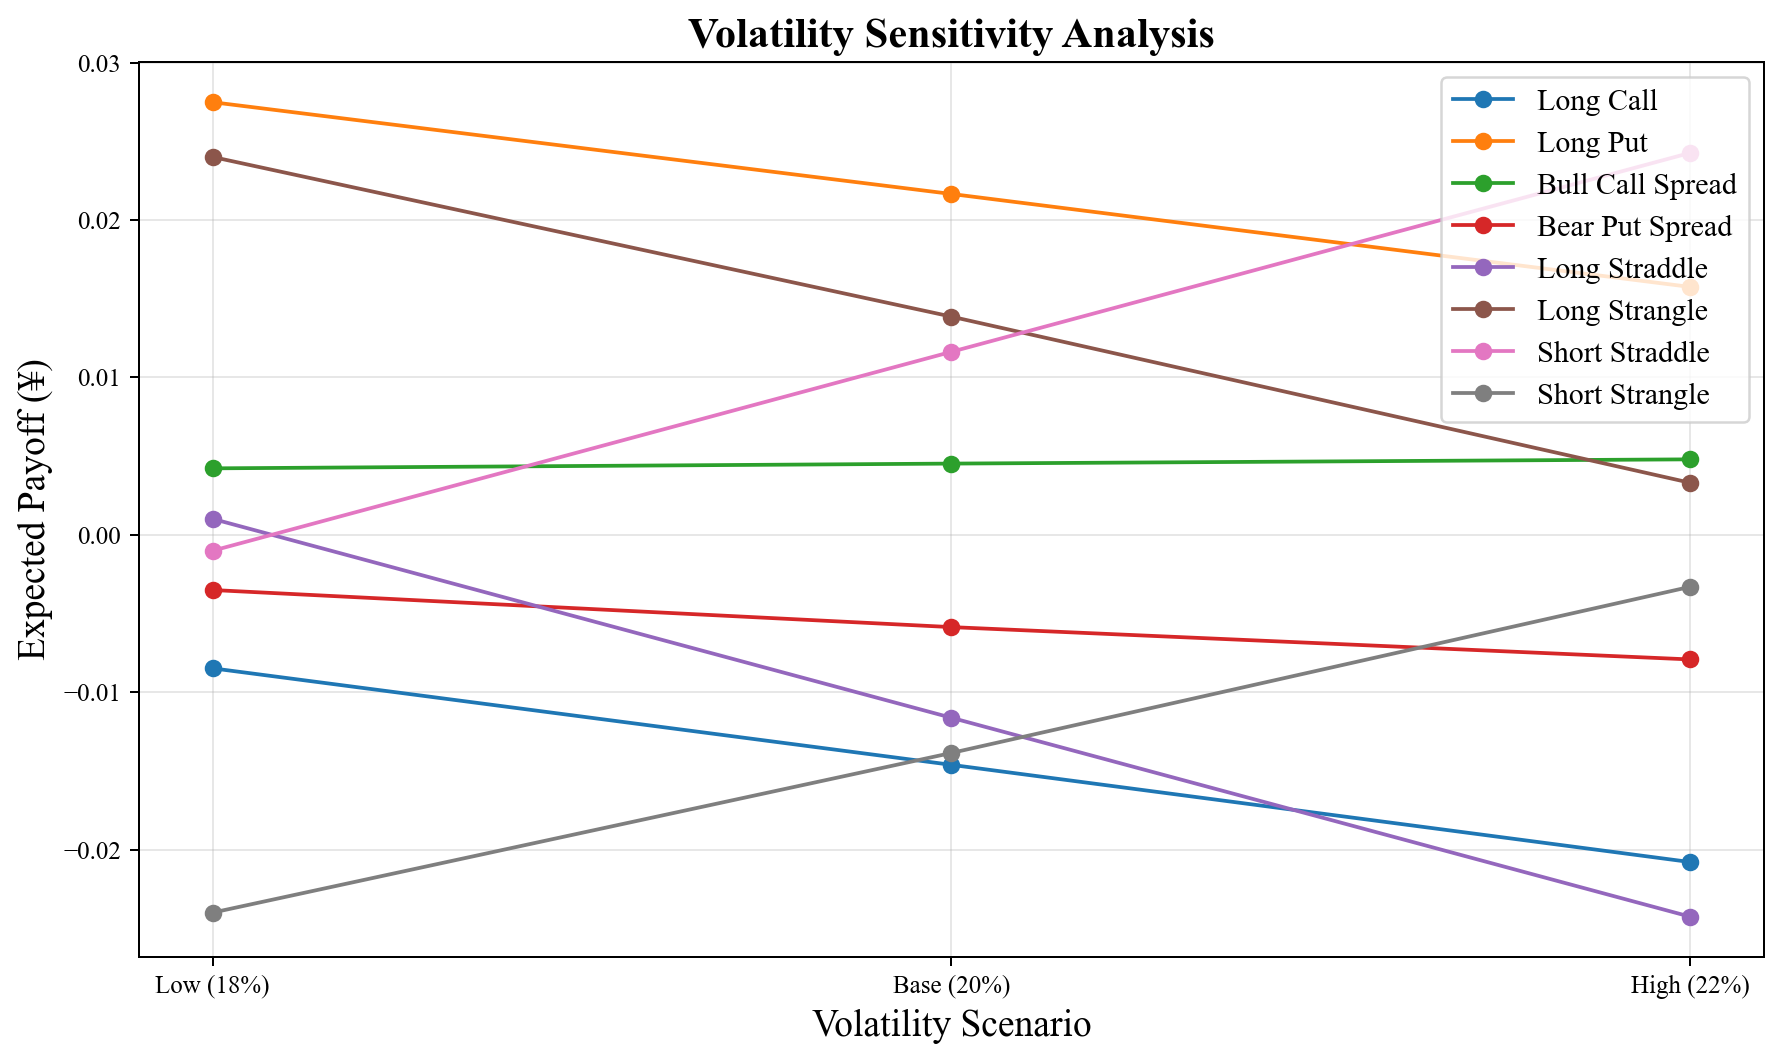

In [6]:
import tushare as ts
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import datetime, timedelta
import warnings
from scipy.stats import norm  # import for Black–Scholes

warnings.filterwarnings('ignore')

mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['savefig.facecolor'] = 'white'

# --- Функции Блэка-Шоулза ---
def black_scholes_call(S, K, T, r, sigma):
    """Calculate Black-Scholes call option price."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def black_scholes_put(S, K, T, r, sigma):
    """Calculate Black-Scholes put option price."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

# --- Tushare API ---
ts.set_token('your_token')  
pro = ts.pro_api()

print("="*80)
print("SSE 50ETF COMPREHENSIVE OPTIONS STRATEGIES BACKTEST")
print("="*80)
print("Testing Strategies:")
print("1. Long Call")
print("2. Long Put") 
print("3. Bull Call Spread")
print("4. Bear Put Spread")
print("5. Long Straddle")
print("6. Long Strangle")
print("7. Short Straddle")
print("8. Short Strangle")
print("="*80)

class OptionsBacktester:
    def __init__(self, start_date='20250515', end_date='20250615'):
        self.start_date = start_date
        self.end_date = end_date
        self.opt_data = None
        self.scenarios = {
            'Bull': {'price': 2.90, 'prob': 0.30},
            'Base': {'price': 2.75, 'prob': 0.50}, 
            'Bear': {'price': 2.40, 'prob': 0.20}
        }
        self.results = {}

    def get_available_options(self):
        try:
            opt = pro.opt_basic(exchange='SSE', fields='ts_code,name,call_put,exercise_price,list_date')
            opt_510050 = opt[opt['name'].str.contains('50ETF')].copy()
            opt_510050['list_date'] = pd.to_datetime(opt_510050['list_date'])
            self.opt_data = opt_510050[opt_510050['list_date'] >= '2025-04-01']
            print(f"Total 50ETF options found: {len(self.opt_data)}")
            print(f"Available strikes: {sorted(self.opt_data['exercise_price'].unique())}")
            return True
        except Exception as e:
            print(f"Error getting option data: {e}")
            return False

    def get_option_price(self, call_put, strike):
        try:
            option = self.opt_data[
                (self.opt_data['call_put'] == call_put) & 
                (self.opt_data['exercise_price'] == strike)
            ].head(1)
            if len(option) == 0:
                available_options = self.opt_data[self.opt_data['call_put'] == call_put]
                strikes = available_options['exercise_price'].unique()
                closest_strike = min(strikes, key=lambda x: abs(x - strike))
                option = available_options[available_options['exercise_price'] == closest_strike].head(1)
                print(f"Using closest {call_put} strike: {closest_strike} (requested: {strike})")
            if len(option) == 0:
                return None, None
            price_data = pro.opt_daily(ts_code=option.iloc[0]['ts_code'], 
                                       start_date=self.start_date, 
                                       end_date=self.end_date)
            time.sleep(0.5)
            return option.iloc[0], price_data
        except Exception as e:
            print(f"Error getting option price for {call_put} {strike}: {e}")
            return None, None

    def calculate_scenario_payoff(self, strategy_name, strategy_params, scenario_price):
        payoff = 0
        if strategy_name == "Long Call":
            strike, premium = strategy_params
            payoff = max(scenario_price - strike, 0) - premium
        elif strategy_name == "Long Put":
            strike, premium = strategy_params
            payoff = max(strike - scenario_price, 0) - premium
        elif strategy_name == "Bull Call Spread":
            long_strike, short_strike, net_premium = strategy_params
            long_payoff = max(scenario_price - long_strike, 0)
            short_payoff = -max(scenario_price - short_strike, 0)
            payoff = long_payoff + short_payoff - net_premium
        elif strategy_name == "Bear Put Spread":
            long_strike, short_strike, net_premium = strategy_params
            long_payoff = max(long_strike - scenario_price, 0)
            short_payoff = -max(short_strike - scenario_price, 0)
            payoff = long_payoff + short_payoff - net_premium
        elif strategy_name == "Long Straddle":
            strike, total_premium = strategy_params
            call_payoff = max(scenario_price - strike, 0)
            put_payoff = max(strike - scenario_price, 0)
            payoff = call_payoff + put_payoff - total_premium
        elif strategy_name == "Long Strangle":
            call_strike, put_strike, total_premium = strategy_params
            call_payoff = max(scenario_price - call_strike, 0)
            put_payoff = max(put_strike - scenario_price, 0)
            payoff = call_payoff + put_payoff - total_premium
        elif strategy_name == "Short Straddle":
            strike, total_premium = strategy_params
            call_payoff = -max(scenario_price - strike, 0)
            put_payoff = -max(strike - scenario_price, 0)
            payoff = call_payoff + put_payoff + total_premium
        elif strategy_name == "Short Strangle":
            call_strike, put_strike, total_premium = strategy_params
            call_payoff = -max(scenario_price - call_strike, 0)
            put_payoff = -max(put_strike - scenario_price, 0)
            payoff = call_payoff + put_payoff + total_premium
        return payoff

    def test_long_call(self, strike=2.80):
        print(f"\n--- Testing Long Call (Strike: {strike}) ---")
        option, price_data = self.get_option_price('C', strike)
        if option is None or len(price_data) == 0:
            return None
        initial_premium = price_data['close'].iloc[0]
        final_value = price_data['close'].iloc[-1]
        scenario_results = {}
        expected_payoff = 0
        for name, scenario in self.scenarios.items():
            payoff = self.calculate_scenario_payoff("Long Call", (strike, initial_premium), scenario['price'])
            scenario_results[name] = payoff
            expected_payoff += scenario['prob'] * payoff
        result = {
            'strategy': 'Long Call',
            'parameters': f'Strike: {strike}',
            'initial_premium': initial_premium,
            'final_value': final_value,
            'total_return': (final_value / initial_premium - 1) * 100,
            'expected_payoff': expected_payoff,
            'scenario_results': scenario_results,
            'price_data': price_data
        }
        self.results['Long Call'] = result
        return result

    def test_long_put(self, strike=2.70):
        print(f"\n--- Testing Long Put (Strike: {strike}) ---")
        option, price_data = self.get_option_price('P', strike)
        if option is None or len(price_data) == 0:
            return None
        initial_premium = price_data['close'].iloc[0]
        final_value = price_data['close'].iloc[-1]
        scenario_results = {}
        expected_payoff = 0
        for name, scenario in self.scenarios.items():
            payoff = self.calculate_scenario_payoff("Long Put", (strike, initial_premium), scenario['price'])
            scenario_results[name] = payoff
            expected_payoff += scenario['prob'] * payoff
        result = {
            'strategy': 'Long Put',
            'parameters': f'Strike: {strike}',
            'initial_premium': initial_premium,
            'final_value': final_value,
            'total_return': (final_value / initial_premium - 1) * 100,
            'expected_payoff': expected_payoff,
            'scenario_results': scenario_results,
            'price_data': price_data
        }
        self.results['Long Put'] = result
        return result

    def test_bull_call_spread(self, long_strike=2.70, short_strike=2.80):
        print(f"\n--- Testing Bull Call Spread ({long_strike}/{short_strike}) ---")
        long_option, long_data = self.get_option_price('C', long_strike)
        short_option, short_data = self.get_option_price('C', short_strike)
        if long_option is None or short_option is None:
            return None
        if len(long_data) == 0 or len(short_data) == 0:
            return None
        merged_data = pd.merge(
            long_data[['trade_date', 'close']].rename(columns={'close': 'long_close'}),
            short_data[['trade_date', 'close']].rename(columns={'close': 'short_close'}),
            on='trade_date', how='inner'
        )
        if len(merged_data) == 0:
            return None
        initial_net_premium = merged_data['long_close'].iloc[0] - merged_data['short_close'].iloc[0]
        final_spread_value = merged_data['long_close'].iloc[-1] - merged_data['short_close'].iloc[-1]
        scenario_results = {}
        expected_payoff = 0
        for name, scenario in self.scenarios.items():
            payoff = self.calculate_scenario_payoff("Bull Call Spread", (long_strike, short_strike, initial_net_premium), scenario['price'])
            scenario_results[name] = payoff
            expected_payoff += scenario['prob'] * payoff
        result = {
            'strategy': 'Bull Call Spread',
            'parameters': f'Long: {long_strike}, Short: {short_strike}',
            'initial_premium': initial_net_premium,
            'final_value': final_spread_value,
            'total_return': (final_spread_value / initial_net_premium - 1) * 100 if initial_net_premium != 0 else 0,
            'expected_payoff': expected_payoff,
            'scenario_results': scenario_results,
            'price_data': merged_data
        }
        self.results['Bull Call Spread'] = result
        return result

    def test_bear_put_spread(self, long_strike=2.70, short_strike=2.60):
        print(f"\n--- Testing Bear Put Spread ({long_strike}/{short_strike}) ---")
        long_option, long_data = self.get_option_price('P', long_strike)
        short_option, short_data = self.get_option_price('P', short_strike)
        if long_option is None or short_option is None:
            return None
        if len(long_data) == 0 or len(short_data) == 0:
            return None
        merged_data = pd.merge(
            long_data[['trade_date', 'close']].rename(columns={'close': 'long_close'}),
            short_data[['trade_date', 'close']].rename(columns={'close': 'short_close'}),
            on='trade_date', how='inner'
        )
        if len(merged_data) == 0:
            return None
        initial_net_premium = merged_data['long_close'].iloc[0] - merged_data['short_close'].iloc[0]
        final_spread_value = merged_data['long_close'].iloc[-1] - merged_data['short_close'].iloc[-1]
        scenario_results = {}
        expected_payoff = 0
        for name, scenario in self.scenarios.items():
            payoff = self.calculate_scenario_payoff("Bear Put Spread", (long_strike, short_strike, initial_net_premium), scenario['price'])
            scenario_results[name] = payoff
            expected_payoff += scenario['prob'] * payoff
        result = {
            'strategy': 'Bear Put Spread',
            'parameters': f'Long: {long_strike}, Short: {short_strike}',
            'initial_premium': initial_net_premium,
            'final_value': final_spread_value,
            'total_return': (final_spread_value / initial_net_premium - 1) * 100 if initial_net_premium != 0 else 0,
            'expected_payoff': expected_payoff,
            'scenario_results': scenario_results,
            'price_data': merged_data
        }
        self.results['Bear Put Spread'] = result
        return result

    def test_long_straddle(self, strike=2.75):
        print(f"\n--- Testing Long Straddle (Strike: {strike}) ---")
        call_option, call_data = self.get_option_price('C', strike)
        put_option, put_data = self.get_option_price('P', strike)
        if call_option is None or put_option is None:
            return None
        if len(call_data) == 0 or len(put_data) == 0:
            return None
        merged_data = pd.merge(
            call_data[['trade_date', 'close']].rename(columns={'close': 'call_close'}),
            put_data[['trade_date', 'close']].rename(columns={'close': 'put_close'}),
            on='trade_date', how='inner'
        )
        if len(merged_data) == 0:
            return None
        merged_data['straddle_value'] = merged_data['call_close'] + merged_data['put_close']
        initial_total_premium = merged_data['straddle_value'].iloc[0]
        final_straddle_value = merged_data['straddle_value'].iloc[-1]
        scenario_results = {}
        expected_payoff = 0
        for name, scenario in self.scenarios.items():
            payoff = self.calculate_scenario_payoff("Long Straddle", (strike, initial_total_premium), scenario['price'])
            scenario_results[name] = payoff
            expected_payoff += scenario['prob'] * payoff
        result = {
            'strategy': 'Long Straddle',
            'parameters': f'Strike: {strike}',
            'initial_premium': initial_total_premium,
            'final_value': final_straddle_value,
            'total_return': (final_straddle_value / initial_total_premium - 1) * 100,
            'expected_payoff': expected_payoff,
            'scenario_results': scenario_results,
            'price_data': merged_data
        }
        self.results['Long Straddle'] = result
        return result

    def test_long_strangle(self, call_strike=2.85, put_strike=2.65):
        print(f"\n--- Testing Long Strangle (Call: {call_strike}, Put: {put_strike}) ---")
        call_option, call_data = self.get_option_price('C', call_strike)
        put_option, put_data = self.get_option_price('P', put_strike)
        if call_option is None or put_option is None:
            return None
        if len(call_data) == 0 or len(put_data) == 0:
            return None
        merged_data = pd.merge(
            call_data[['trade_date', 'close']].rename(columns={'close': 'call_close'}),
            put_data[['trade_date', 'close']].rename(columns={'close': 'put_close'}),
            on='trade_date', how='inner'
        )
        if len(merged_data) == 0:
            return None
        merged_data['strangle_value'] = merged_data['call_close'] + merged_data['put_close']
        initial_total_premium = merged_data['strangle_value'].iloc[0]
        final_strangle_value = merged_data['strangle_value'].iloc[-1]
        scenario_results = {}
        expected_payoff = 0
        for name, scenario in self.scenarios.items():
            payoff = self.calculate_scenario_payoff("Long Strangle", (call_strike, put_strike, initial_total_premium), scenario['price'])
            scenario_results[name] = payoff
            expected_payoff += scenario['prob'] * payoff
        result = {
            'strategy': 'Long Strangle',
            'parameters': f'Call: {call_strike}, Put: {put_strike}',
            'initial_premium': initial_total_premium,
            'final_value': final_strangle_value,
            'total_return': (final_strangle_value / initial_total_premium - 1) * 100,
            'expected_payoff': expected_payoff,
            'scenario_results': scenario_results,
            'price_data': merged_data
        }
        self.results['Long Strangle'] = result
        return result

    def test_short_straddle(self, strike=2.75):
        print(f"\n--- Testing Short Straddle (Strike: {strike}) ---")
        call_option, call_data = self.get_option_price('C', strike)
        put_option, put_data = self.get_option_price('P', strike)
        if call_option is None or put_option is None:
            return None
        if len(call_data) == 0 or len(put_data) == 0:
            return None
        merged_data = pd.merge(
            call_data[['trade_date', 'close']].rename(columns={'close': 'call_close'}),
            put_data[['trade_date', 'close']].rename(columns={'close': 'put_close'}),
            on='trade_date', how='inner'
        )
        if len(merged_data) == 0:
            return None
        initial_total_premium = merged_data['call_close'].iloc[0] + merged_data['put_close'].iloc[0]
        final_total_value = merged_data['call_close'].iloc[-1] + merged_data['put_close'].iloc[-1]
        final_straddle_pnl = initial_total_premium - final_total_value
        scenario_results = {}
        expected_payoff = 0
        for name, scenario in self.scenarios.items():
            payoff = self.calculate_scenario_payoff("Short Straddle", (strike, initial_total_premium), scenario['price'])
            scenario_results[name] = payoff
            expected_payoff += scenario['prob'] * payoff
        result = {
            'strategy': 'Short Straddle',
            'parameters': f'Strike: {strike}',
            'initial_premium': initial_total_premium,
            'final_value': final_straddle_pnl,
            'total_return': (final_straddle_pnl / initial_total_premium) * 100,
            'expected_payoff': expected_payoff,
            'scenario_results': scenario_results,
            'price_data': merged_data
        }
        self.results['Short Straddle'] = result
        return result

    def test_short_strangle(self, call_strike=2.85, put_strike=2.65):
        print(f"\n--- Testing Short Strangle (Call: {call_strike}, Put: {put_strike}) ---")
        call_option, call_data = self.get_option_price('C', call_strike)
        put_option, put_data = self.get_option_price('P', put_strike)
        if call_option is None or put_option is None:
            return None
        if len(call_data) == 0 or len(put_data) == 0:
            return None
        merged_data = pd.merge(
            call_data[['trade_date', 'close']].rename(columns={'close': 'call_close'}),
            put_data[['trade_date', 'close']].rename(columns={'close': 'put_close'}),
            on='trade_date', how='inner'
        )
        if len(merged_data) == 0:
            return None
        initial_total_premium = merged_data['call_close'].iloc[0] + merged_data['put_close'].iloc[0]
        final_total_value = merged_data['call_close'].iloc[-1] + merged_data['put_close'].iloc[-1]
        final_strangle_pnl = initial_total_premium - final_total_value
        scenario_results = {}
        expected_payoff = 0
        for name, scenario in self.scenarios.items():
            payoff = self.calculate_scenario_payoff("Short Strangle", (call_strike, put_strike, initial_total_premium), scenario['price'])
            scenario_results[name] = payoff
            expected_payoff += scenario['prob'] * payoff
        result = {
            'strategy': 'Short Strangle',
            'parameters': f'Call: {call_strike}, Put: {put_strike}',
            'initial_premium': initial_total_premium,
            'final_value': final_strangle_pnl,
            'total_return': (final_strangle_pnl / initial_total_premium) * 100,
            'expected_payoff': expected_payoff,
            'scenario_results': scenario_results,
            'price_data': merged_data
        }
        self.results['Short Strangle'] = result
        return result

    def volatility_sensitivity_analysis(self):
        print("\n" + "="*80)
        print("VOLATILITY SENSITIVITY ANALYSIS")
        print("="*80)
        
        # Параметры для Блэк-Шоулза
        S = 2.75  # Текущая цена актива (из Base сценария)
        T = 1/12  # 1 месяц
        r = 0.03  # Безрисковая ставка
        vol_scenarios = [0.18, 0.20, 0.22]  # Низкая, базовая, высокая волатильность
        vol_labels = ['Low (18%)', 'Base (20%)', 'High (22%)']
        
        vol_results = []
        
        for strategy_name, result in self.results.items():
            if result is None:
                continue
            params = result['parameters']
            initial_premium = result['initial_premium']
            
            # Извлекаем страйки и другие параметры для каждой стратегии
            if strategy_name == "Long Call":
                strike = float(params.split(': ')[1])
                for vol, vol_label in zip(vol_scenarios, vol_labels):
                    call_price = black_scholes_call(S, strike, T, r, vol)
                    expected_payoff = sum(
                        self.scenarios[sc]['prob'] * self.calculate_scenario_payoff(
                            strategy_name, (strike, call_price), self.scenarios[sc]['price']
                        ) for sc in self.scenarios
                    )
                    vol_results.append({
                        'Strategy': strategy_name,
                        'Volatility': vol_label,
                        'Expected Payoff': expected_payoff
                    })
                    
            elif strategy_name == "Long Put":
                strike = float(params.split(': ')[1])
                for vol, vol_label in zip(vol_scenarios, vol_labels):
                    put_price = black_scholes_put(S, strike, T, r, vol)
                    expected_payoff = sum(
                        self.scenarios[sc]['prob'] * self.calculate_scenario_payoff(
                            strategy_name, (strike, put_price), self.scenarios[sc]['price']
                        ) for sc in self.scenarios
                    )
                    vol_results.append({
                        'Strategy': strategy_name,
                        'Volatility': vol_label,
                        'Expected Payoff': expected_payoff
                    })
                    
            elif strategy_name == "Bull Call Spread":
                long_strike = float(params.split(', ')[0].split(': ')[1])
                short_strike = float(params.split(', ')[1].split(': ')[1])
                for vol, vol_label in zip(vol_scenarios, vol_labels):
                    long_call_price = black_scholes_call(S, long_strike, T, r, vol)
                    short_call_price = black_scholes_call(S, short_strike, T, r, vol)
                    net_premium = long_call_price - short_call_price
                    expected_payoff = sum(
                        self.scenarios[sc]['prob'] * self.calculate_scenario_payoff(
                            strategy_name, (long_strike, short_strike, net_premium), self.scenarios[sc]['price']
                        ) for sc in self.scenarios
                    )
                    vol_results.append({
                        'Strategy': strategy_name,
                        'Volatility': vol_label,
                        'Expected Payoff': expected_payoff
                    })
                    
            elif strategy_name == "Bear Put Spread":
                long_strike = float(params.split(', ')[0].split(': ')[1])
                short_strike = float(params.split(', ')[1].split(': ')[1])
                for vol, vol_label in zip(vol_scenarios, vol_labels):
                    long_put_price = black_scholes_put(S, long_strike, T, r, vol)
                    short_put_price = black_scholes_put(S, short_strike, T, r, vol)
                    net_premium = long_put_price - short_put_price
                    expected_payoff = sum(
                        self.scenarios[sc]['prob'] * self.calculate_scenario_payoff(
                            strategy_name, (long_strike, short_strike, net_premium), self.scenarios[sc]['price']
                        ) for sc in self.scenarios
                    )
                    vol_results.append({
                        'Strategy': strategy_name,
                        'Volatility': vol_label,
                        'Expected Payoff': expected_payoff
                    })
                    
            elif strategy_name == "Long Straddle":
                strike = float(params.split(': ')[1])
                for vol, vol_label in zip(vol_scenarios, vol_labels):
                    call_price = black_scholes_call(S, strike, T, r, vol)
                    put_price = black_scholes_put(S, strike, T, r, vol)
                    total_premium = call_price + put_price
                    expected_payoff = sum(
                        self.scenarios[sc]['prob'] * self.calculate_scenario_payoff(
                            strategy_name, (strike, total_premium), self.scenarios[sc]['price']
                        ) for sc in self.scenarios
                    )
                    vol_results.append({
                        'Strategy': strategy_name,
                        'Volatility': vol_label,
                        'Expected Payoff': expected_payoff
                    })
                    
            elif strategy_name == "Long Strangle":
                call_strike = float(params.split(', ')[0].split(': ')[1])
                put_strike = float(params.split(', ')[1].split(': ')[1])
                for vol, vol_label in zip(vol_scenarios, vol_labels):
                    call_price = black_scholes_call(S, call_strike, T, r, vol)
                    put_price = black_scholes_put(S, put_strike, T, r, vol)
                    total_premium = call_price + put_price
                    expected_payoff = sum(
                        self.scenarios[sc]['prob'] * self.calculate_scenario_payoff(
                            strategy_name, (call_strike, put_strike, total_premium), self.scenarios[sc]['price']
                        ) for sc in self.scenarios
                    )
                    vol_results.append({
                        'Strategy': strategy_name,
                        'Volatility': vol_label,
                        'Expected Payoff': expected_payoff
                    })
                    
            elif strategy_name == "Short Straddle":
                strike = float(params.split(': ')[1])
                for vol, vol_label in zip(vol_scenarios, vol_labels):
                    call_price = black_scholes_call(S, strike, T, r, vol)
                    put_price = black_scholes_put(S, strike, T, r, vol)
                    total_premium = call_price + put_price
                    expected_payoff = sum(
                        self.scenarios[sc]['prob'] * self.calculate_scenario_payoff(
                            strategy_name, (strike, total_premium), self.scenarios[sc]['price']
                        ) for sc in self.scenarios
                    )
                    vol_results.append({
                        'Strategy': strategy_name,
                        'Volatility': vol_label,
                        'Expected Payoff': expected_payoff
                    })
                    
            elif strategy_name == "Short Strangle":
                call_strike = float(params.split(', ')[0].split(': ')[1])
                put_strike = float(params.split(', ')[1].split(': ')[1])
                for vol, vol_label in zip(vol_scenarios, vol_labels):
                    call_price = black_scholes_call(S, call_strike, T, r, vol)
                    put_price = black_scholes_put(S, put_strike, T, r, vol)
                    total_premium = call_price + put_price
                    expected_payoff = sum(
                        self.scenarios[sc]['prob'] * self.calculate_scenario_payoff(
                            strategy_name, (call_strike, put_strike, total_premium), self.scenarios[sc]['price']
                        ) for sc in self.scenarios
                    )
                    vol_results.append({
                        'Strategy': strategy_name,
                        'Volatility': vol_label,
                        'Expected Payoff': expected_payoff
                    })
        
        # Вывод результатов в таблице
        if vol_results:
            vol_df = pd.DataFrame(vol_results)
            print("\nExpected Payoffs under Different Volatility Scenarios:")
            print(vol_df.pivot(index='Strategy', columns='Volatility', values='Expected Payoff').to_string())
            
            # Создание графика
            plt.figure(figsize=(10, 6), dpi=180)
            for strategy in vol_df['Strategy'].unique():
                strategy_data = vol_df[vol_df['Strategy'] == strategy]
                plt.plot(vol_labels, strategy_data['Expected Payoff'], marker='o', label=strategy)
            plt.title('Volatility Sensitivity Analysis', fontweight='bold', fontsize=17, fontname='Times New Roman')
            plt.xlabel('Volatility Scenario', fontsize=15, fontname='Times New Roman')
            plt.ylabel('Expected Payoff (¥)', fontsize=15, fontname='Times New Roman')
            plt.grid(True, alpha=0.3)
            plt.legend(fontsize=12, loc='best')
            plt.tight_layout()
            plt.show()

    def run_all_tests(self):
        print("\nRunning comprehensive options strategy backtest...")
        if not self.get_available_options():
            print("Failed to get options data")
            return
        self.test_long_call()
        self.test_long_put()
        self.test_bull_call_spread()
        self.test_bear_put_spread()
        self.test_long_straddle()
        self.test_long_strangle()
        self.test_short_straddle()
        self.test_short_strangle()

    def print_summary(self):
        print("\n" + "="*100)
        print("COMPREHENSIVE OPTIONS STRATEGIES BACKTEST SUMMARY")
        print("="*100)
        summary_data = []
        for strategy_name, result in self.results.items():
            if result is not None:
                summary_data.append({
                    'Strategy': strategy_name,
                    'Parameters': result['parameters'],
                    'Initial Premium': f"{result['initial_premium']:.4f}",
                    'Final Value': f"{result['final_value']:.4f}",
                    'Total Return (%)': f"{result['total_return']:.2f}",
                    'Expected Payoff': f"{result['expected_payoff']:.4f}",
                    'Bull Scenario': f"{result['scenario_results']['Bull']:.4f}",
                    'Base Scenario': f"{result['scenario_results']['Base']:.4f}",
                    'Bear Scenario': f"{result['scenario_results']['Bear']:.4f}"
                })
        if summary_data:
            df_summary = pd.DataFrame(summary_data)
            print(df_summary.to_string(index=False))
            best_expected = max(summary_data, key=lambda x: float(x['Expected Payoff']))
            best_return = max(summary_data, key=lambda x: float(x['Total Return (%)']))
            print("\n" + "-"*80)
            print("BEST PERFORMING STRATEGIES:")
            print("-"*80)
            print(f"Best Expected Payoff: {best_expected['Strategy']} ({best_expected['Expected Payoff']} ¥)")
            print(f"Best Historical Return: {best_return['Strategy']} ({best_return['Total Return (%)']}%)")
            positive_expected = [s for s in summary_data if float(s['Expected Payoff']) > 0]
            negative_expected = [s for s in summary_data if float(s['Expected Payoff']) <= 0]
            print(f"\nStrategies with Positive Expected Payoff: {len(positive_expected)}")
            print(f"Strategies with Negative Expected Payoff: {len(negative_expected)}")
            if positive_expected:
                print("\nRecommended Strategies (Positive Expected Return):")
                for s in sorted(positive_expected, key=lambda x: float(x['Expected Payoff']), reverse=True):
                    print(f"  • {s['Strategy']}: {s['Expected Payoff']} ¥ expected payoff")
        print("="*100)

    def create_comparison_visualization(self):
        if not self.results:
            return
        strategies = []
        returns = []
        expected_payoffs = []
        scenario_labels = ['Bull', 'Base', 'Bear']
        scenario_matrix = []
        for strategy_name, result in self.results.items():
            if result is not None:
                strategies.append(strategy_name)
                returns.append(result['total_return'])
                expected_payoffs.append(result['expected_payoff'])
                scenario_values = [result['scenario_results'][label] for label in scenario_labels]
                scenario_matrix.append(scenario_values)
        if not strategies:
            return
        # Plot 1: Historical Returns
        plt.figure(figsize=(12, 7), dpi=180)
        colors = plt.cm.RdYlGn([0.8 if r > 0 else 0.2 for r in returns])
        bars1 = plt.bar(range(len(strategies)), returns, color=colors)
        plt.title('Historical Returns (%)', fontweight='bold', fontsize=17, fontname='Times New Roman')
        plt.ylabel('Return (%)', fontsize=15, fontname='Times New Roman')
        plt.xticks(range(len(strategies)), strategies, rotation=45, ha='right', fontsize=13, fontname='Times New Roman')
        plt.axhline(0, color='black', linestyle='-', alpha=0.5)
        plt.grid(True, alpha=0.3)
        for bar, value in zip(bars1, returns):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + (1 if height >= 0 else -3),
                     f'{value:.1f}%', ha='center', va='bottom' if height >= 0 else 'top', fontname='Times New Roman', fontsize=12)
        plt.tight_layout()
        plt.show()
        # plt.savefig('historical_returns.png', dpi=300, bbox_inches='tight')

        # Plot 2: Expected Payoffs
        plt.figure(figsize=(12, 7), dpi=180)
        colors2 = plt.cm.RdYlGn([0.8 if ep > 0 else 0.2 for ep in expected_payoffs])
        bars2 = plt.bar(range(len(strategies)), expected_payoffs, color=colors2)
        plt.title('Expected Payoffs (¥)', fontweight='bold', fontsize=17, fontname='Times New Roman')
        plt.ylabel('Expected Payoff (¥)', fontsize=15, fontname='Times New Roman')
        plt.xticks(range(len(strategies)), strategies, rotation=45, ha='right', fontsize=13, fontname='Times New Roman')
        plt.axhline(0, color='black', linestyle='-', alpha=0.5)
        plt.grid(True, alpha=0.3)
        for bar, value in zip(bars2, expected_payoffs):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height >= 0 else -0.01),
                     f'{value:.3f}', ha='center', va='bottom' if height >= 0 else 'top', fontname='Times New Roman', fontsize=12)
        plt.tight_layout()
        plt.show()
        # plt.savefig('expected_payoffs.png', dpi=300, bbox_inches='tight')

        # Plot 3: Scenario Analysis Heatmap
        plt.figure(figsize=(9, 7), dpi=180)
        im = plt.imshow(scenario_matrix, cmap='RdYlGn', aspect='auto')
        plt.title('Scenario Analysis Heatmap', fontweight='bold', fontsize=17, fontname='Times New Roman')
        plt.yticks(range(len(strategies)), strategies, fontsize=13, fontname='Times New Roman')
        plt.xticks(range(len(scenario_labels)), scenario_labels, fontsize=14, fontname='Times New Roman')
        for i in range(len(strategies)):
            for j in range(len(scenario_labels)):
                plt.text(j, i, f'{scenario_matrix[i][j]:.3f}',
                         ha="center", va="center", color="black", fontsize=10, fontname='Times New Roman')
        plt.colorbar(im, label='Payoff (¥)')
        plt.tight_layout()
        plt.show()
        # plt.savefig('scenario_heatmap.png', dpi=300, bbox_inches='tight')

        # Plot 4: Risk-Return Scatter
        plt.figure(figsize=(10, 7), dpi=180)
        plt.scatter(expected_payoffs, returns, s=110, alpha=0.8, c=range(len(strategies)), cmap='tab10')
        plt.xlabel('Expected Payoff (¥)', fontsize=15, fontname='Times New Roman')
        plt.ylabel('Historical Return (%)', fontsize=15, fontname='Times New Roman')
        plt.title('Risk-Return Analysis', fontweight='bold', fontsize=17, fontname='Times New Roman')
        plt.axhline(0, color='black', linestyle='--', alpha=0.5)
        plt.axvline(0, color='black', linestyle='--', alpha=0.5)
        plt.grid(True, alpha=0.3)
        for i, strategy in enumerate(strategies):
            plt.annotate(strategy, (expected_payoffs[i], returns[i]),
                         xytext=(6, 6), textcoords='offset points', fontsize=11, fontname='Times New Roman')
        plt.tight_layout()
        plt.show()

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    backtester = OptionsBacktester(start_date='20250515', end_date='20250615')
    backtester.run_all_tests()
    backtester.print_summary()
    backtester.create_comparison_visualization()
    backtester.volatility_sensitivity_analysis()  # Volatility

if __name__ == "__main__":
    main()